In [27]:
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import pandas as pd




## Step 1: Load the dataset & Extract Features

In [24]:
df = pd.read_csv( r"C:\Users\Admin\Documents\GitHub\METABRIC-Mutation-Clustering\METABRIC_RNA_Mutation.csv", low_memory=False)

In [25]:
for col in df.columns:
    print(col)

patient_id
age_at_diagnosis
type_of_breast_surgery
cancer_type
cancer_type_detailed
cellularity
chemotherapy
pam50_+_claudin-low_subtype
cohort
er_status_measured_by_ihc
er_status
neoplasm_histologic_grade
her2_status_measured_by_snp6
her2_status
tumor_other_histologic_subtype
hormone_therapy
inferred_menopausal_state
integrative_cluster
primary_tumor_laterality
lymph_nodes_examined_positive
mutation_count
nottingham_prognostic_index
oncotree_code
overall_survival_months
overall_survival
pr_status
radio_therapy
3-gene_classifier_subtype
tumor_size
tumor_stage
death_from_cancer
brca1
brca2
palb2
pten
tp53
atm
cdh1
chek2
nbn
nf1
stk11
bard1
mlh1
msh2
msh6
pms2
epcam
rad51c
rad51d
rad50
rb1
rbl1
rbl2
ccna1
ccnb1
cdk1
ccne1
cdk2
cdc25a
ccnd1
cdk4
cdk6
ccnd2
cdkn2a
cdkn2b
myc
cdkn1a
cdkn1b
e2f1
e2f2
e2f3
e2f4
e2f5
e2f6
e2f7
e2f8
src
jak1
jak2
stat1
stat2
stat3
stat5a
stat5b
mdm2
tp53bp1
adam10
adam17
aph1a
aph1b
arrdc1
cir1
ctbp1
ctbp2
cul1
dll1
dll3
dll4
dtx1
dtx2
dtx3
dtx4
ep300
fbxw7
hda

### Extract gene-expression features

In [6]:
# 1. Columns ending in "_mut" → mutation features (exclude)
mut_cols = [col for col in df.columns if col.endswith("_mut")]

# 2. Clinical columns (exclude)
clinical_cols = [
    'patient_id', 'age_at_diagnosis', 'type_of_breast_surgery', 'cancer_type', 
    'cancer_type_detailed', 'cellularity', 'chemotherapy', 
    'pam50_+_claudin-low_subtype', 'cohort', 'er_status_measured_by_ihc', 
    'er_status', 'neoplasm_histologic_grade', 'her2_status_measured_by_snp6',
    'her2_status', 'tumor_other_histologic_subtype', 'hormone_therapy',
    'inferred_menopausal_state', 'integrative_cluster', 
    'primary_tumor_laterality', 'lymph_nodes_examined_positive',
    'mutation_count', 'nottingham_prognostic_index', 'oncotree_code',
    'overall_survival_months', 'overall_survival', 'pr_status', 
    'radio_therapy', '3-gene_classifier_subtype', 'tumor_size',
    'tumor_stage', 'death_from_cancer'
]

# 3. Gene expression columns = everything else
gene_cols = [
    col for col in df.columns 
    if col not in clinical_cols and col not in mut_cols
]

print("Number of gene-expression features:", len(gene_cols))
print("Example:", gene_cols[:20])

Number of gene-expression features: 489
Example: ['brca1', 'brca2', 'palb2', 'pten', 'tp53', 'atm', 'cdh1', 'chek2', 'nbn', 'nf1', 'stk11', 'bard1', 'mlh1', 'msh2', 'msh6', 'pms2', 'epcam', 'rad51c', 'rad51d', 'rad50']


**✅ Why Did We Extract Only Gene Expression Features?**

Breast cancer datasets like METABRIC contain three big categories of information:

1. Clinical data

(age, tumor size, stage, therapy, etc.)

2. Mutation data

(columns ending with _mut → whether a gene is mutated)

3. Gene expression data (RNA-seq Z-scores)

These measure how active each gene is in the tumor.

#### **🔬 Why we ONLY use gene expression features for PCA + Clustering**

**✔ 1. Clustering based on biological patterns**

PCA and clustering are used to see if tumors naturally group into molecular subtypes.

Clinical features do not capture molecular differences.
Mutations are binary and sparse.

➡️ Gene expression features reflect actual tumor biology.

**✔ 2. PCA needs continuous, high-dimensional data**

RNA-seq expression is:
- Continuous
- High-dimensional (300–500 genes)
- Suitable for dimensionality reduction

Clinical + mutation data are not suitable for PCA visual separation.

**✔ 3. Many cancer subtypes are defined by gene expression**

Metabric is famous for:
**PAM50, Integrative clusters, 3-gene subtype,** etc.

All of these come from gene-expression patterns, so PCA/clustering must use the same type of data.

**✔ 4. Mutation columns (_mut) pollute PCA**

They are 0/1 values → PCA cannot extract meaningful variance → PCA becomes meaningless.

**🎯 Conclusion**

We isolated gene-expression features because:

**Clustering and PCA in cancer genomics are ALWAYS performed on RNA-expression data, not clinical or mutation data.**

This gives biologically meaningful groups and clean visual patterns.

## Step 2: Preprocess Gene Expression Matrix

- Now we take the extracted gene_cols and prepare them for PCA + clustering.

#### Scaling & Checking Variance

In [7]:
# Extract only the gene-expression data
X_genes = df[gene_cols].copy()

# 1. Check missing values
missing = X_genes.isna().sum().sum()
print("Total missing values in gene matrix:", missing)

# If any missing → fill with 0 (neutral for Z-scores)
X_genes = X_genes.fillna(0)

# 2. Remove zero-variance genes (very rare but safe)
from sklearn.feature_selection import VarianceThreshold

var_filter = VarianceThreshold(threshold=0.0)
X_genes_filtered = var_filter.fit_transform(X_genes)

print("Original gene count:", X_genes.shape[1])
print("After removing zero-variance:", X_genes_filtered.shape[1])

# 3. (Optional but recommended) Standardize again for PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_genes_filtered)

print("Final scaled gene expression shape:", X_scaled.shape)

Total missing values in gene matrix: 0
Original gene count: 489
After removing zero-variance: 489
Final scaled gene expression shape: (1904, 489)


Meaning:

- The dataset has 1904 samples

- 489 RNA-expression genes

- All cleaned & ready for PCA & clustering

## Step 3: PCA on Gene Expression Data

####  3.1 Fit PCA

In [8]:
# Fit PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

print("PCA shape:", X_pca.shape)

PCA shape: (1904, 489)


#### 3.2 Scree Plot (Explained Variance Plot)

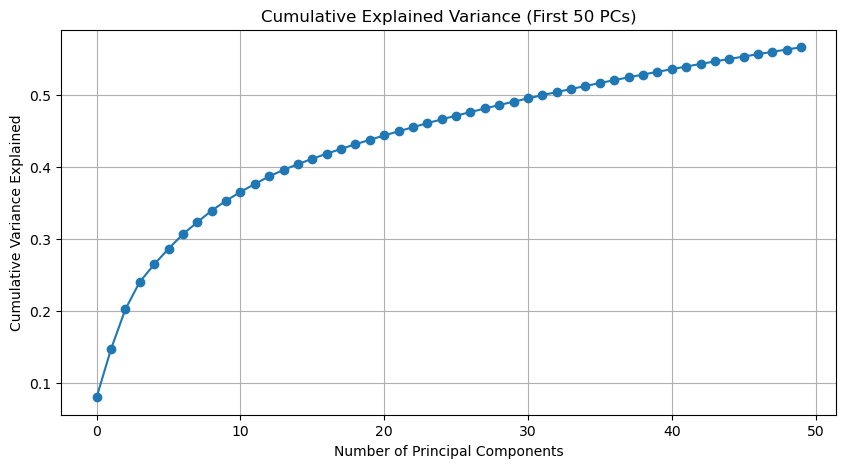

In [9]:
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_)[:50], marker='o')
plt.title("Cumulative Explained Variance (First 50 PCs)")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.grid(True)
plt.show()

The explained variance curve shows that:
- PC1 explains ~8% of the variance.
- The first 10 PCs explain ~35%.
- The first 40 PCs are needed to reach ~50%.

This means the gene-expression data is **high-dimensional** and contains no single dominant direction of variation. Such patterns are typical in genomic datasets. PCA still provides a cleaner, noise-reduced representation suitable for clustering.

**In simple words:**

- Each PCA component is like a compressed summary of many genes.

- The first few components capture some of the important patterns, but not most of them.

- Even after 10 components, we only capture about one-third of all information.

- We need around 40+ components to reach half of the total information.

**Why this happens:**

Gene expression is extremely complex, hundreds of genes change together in small ways.
There isn’t one big factor that explains everything.

**➡️ So PCA helps reduce complexity, but we cannot rely on only 2-3 components to describe everything.**

#### 3.3 Visualize PCA (PC1 vs PC2)

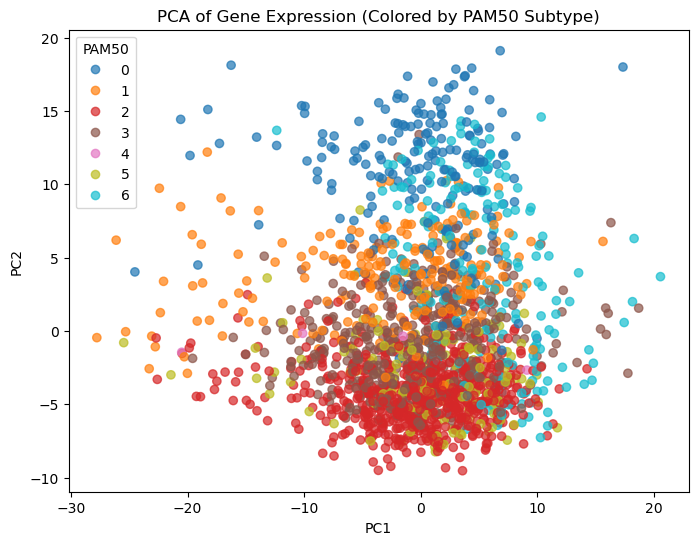

In [10]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    X_pca[:,0], X_pca[:,1],
    c=pd.Categorical(df["pam50_+_claudin-low_subtype"]).codes,
    cmap='tab10',
    alpha=0.7
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Gene Expression (Colored by PAM50 Subtype)")
plt.legend(*scatter.legend_elements(), title="PAM50")
plt.show()

The scatter plot of PC1 vs PC2, colored by PAM50 subtypes, shows partial but incomplete separation between subtypes:
- Some groups cluster more compactly.
- Others overlap substantially.

This is expected because PC1 and PC2 capture only a small portion of total variability.  
However, the visualization confirms that PCA reveals **biologically meaningful structure**, which will be useful for downstream **clustering**.

Overall, PCA effectively reduces dimensionality and highlights patterns that are not directly visible in the raw 489-gene space.

**In simple words:**

- The dots do not form perfectly separate groups.

- Some subtypes are loosely grouped together, but there is **overlap.**

- This is expected because we squeezed **489 genes into only 2 dimensions.**

**What this really means:**

- Breast cancer types are biologically complex.

- They don’t fall into simple, clean clusters when viewed in 2D.

- But we can still see **patterns**, some subtypes cluster more tightly than others.

**➡️ PCA helps us visualize hidden trends, even if the groups are not cleanly separated.**

#### 3.4 Choose number of PCs for clustering

In [11]:
pca_n = 30
X_pca_reduced = X_pca[:, :pca_n]

print("Reduced PCA shape:", X_pca_reduced.shape)

Reduced PCA shape: (1904, 30)


## Step 4: Clustering the PCA-reduced Data

**Why cluster?**

We want to discover hidden patient groups based only on genes, then compare them with known clinical subtypes (PAM50) to see if the clustering matches biology.

#### 4.1 Choose number of Clusters

**We'll be using 30 PCs. Why 30 PCs?**

✔ **20 PCs capture ~45% variance** → good but might miss some subtle gene-expression patterns

✔ **30 PCs capture ~50% variance** → sweet spot for clustering

✔ **50 PCs add noise** → might degrade clustering performance

✔ METABRIC gene expression has complex structure - 30 PCs is commonly used in research pipelines.

**So 30 PCs is the best balance between:**

- noise reduction

- biological signal preservation

- cluster separation

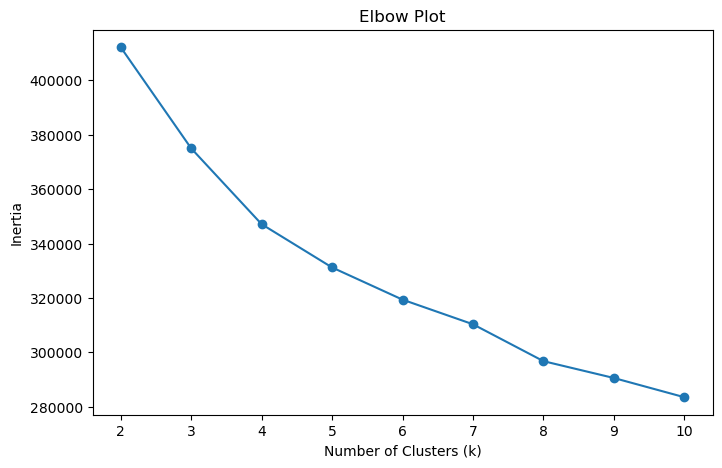

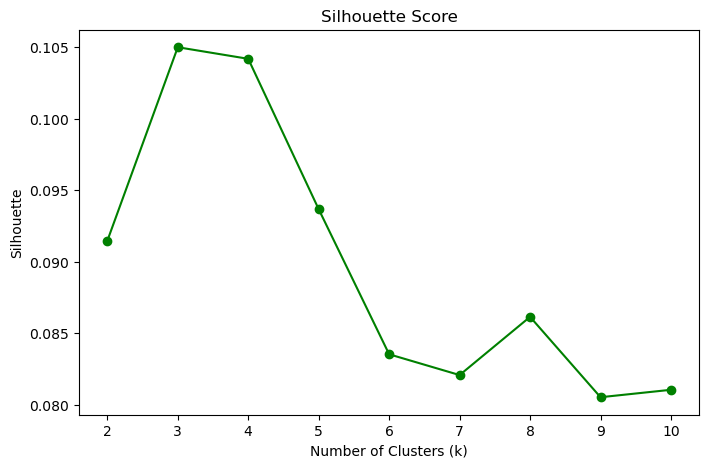

In [26]:
# Suppress the specific KMeans warning
warnings.filterwarnings(
    "ignore",
    message="KMeans is known to have a memory leak on Windows with MKL"
)

# Use first 30 PCA components
X_pca_reduced = X_pca[:, :30]

# Evaluate K from 2 to 10
inertias = []
silhouettes = []

K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca_reduced)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_pca_reduced, labels))

# Plot Elbow
plt.figure(figsize=(8,5))
plt.plot(K_range, inertias, marker='o')
plt.title("Elbow Plot")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()

# Plot Silhouette
plt.figure(figsize=(8,5))
plt.plot(K_range, silhouettes, marker='o', color='green')
plt.title("Silhouette Score")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette")
plt.show()

**📌 1. Elbow Plot Interpretation**

The elbow plot shows how the **within-cluster distance (inertia)** decreases as we increase the number of clusters k.

The inertia drops sharply between k = 2 and k = 4, after which the curve begins to flatten.  
This indicates that adding clusters beyond k = 4 gives very little improvement.  
Thus, the elbow point lies around **k = 3-4**.

**📌 2. Silhouette Score Interpretation**

The silhouette score measures how well-separated and compact the clusters are. **Higher = better.**

The silhouette score is highest at **k = 3**, meaning the samples are most well-separated and compact at this cluster count.  
Scores decrease noticeably for k > 4, which shows that additional clusters reduce quality.

► **Final Choice:** Based on both plots, the optimal number of clusters is **k = 3**.

#### 4.2 Fit the chosen clustering model

In [32]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca_reduced)

df["Cluster"] = cluster_labels

#### 4.3 Visualize clusters in PCA space

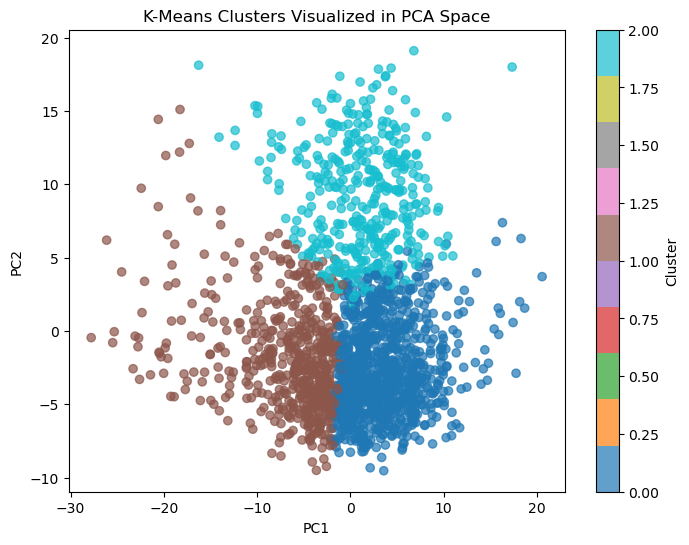

In [33]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=cluster_labels, cmap='tab10', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-Means Clusters Visualized in PCA Space")
plt.colorbar(label="Cluster")
plt.show()

### *“K-Means Clusters Visualized in PCA Space”*

This scatter plot shows how the **three discovered gene-expression clusters** are spread out when we look at only two PCA dimensions (PC1 & PC2).

**What it shows in simple terms:**

- The algorithm grouped patients into 3 clusters based only on their gene expression.

- Each color represents one cluster.

- We see that the clusters separate reasonably well:

   -> One group is more to the left,

   -> One group is more right,

   -> One group is more to the top.

Even though gene expression is extremely high-dimensional, PCA helps us see that the clusters form **distinct patterns**, meaning the algorithm is capturing **real biological differences** between patients.

#### 4.4 Compare clusters with PAM50 Subtypes

In [34]:
pd.crosstab(df["Cluster"], df["pam50_+_claudin-low_subtype"])

pam50_+_claudin-low_subtype,Basal,Her2,LumA,LumB,NC,Normal,claudin-low
Cluster,,,,,,,
0,8,56,432,252,2,95,97
1,10,87,246,190,4,38,1
2,181,77,1,19,0,7,101


- The table shows how our 3 machine-learning clusters align with seven real patient groups that doctors use (Basal, Her2, LumA, LumB, etc.).

⭐ Cluster 2

- Almost all patients in this cluster come from **only two medical groups (Basal and Claudin-low patients).**

- These types are usually more aggressive cancers.

✔️ Our clustering clearly separated this aggressive group.

⭐ Cluster 0

- This cluster mostly contains **LumA** and **LumB** patients.

- These patients share a different set of gene-expression patterns.

- These are usually less aggressive, slower-growing cancers.

✔️ This cluster grouped the more stable cancer types together.

⭐ Cluster 1

- This cluster is more mixed, containing several medical groups. A mix of **LumA, LumB,** and **Her2.**

- It represents patients whose gene patterns are **in between** the other two clusters.  

### **🔍 Main thing to understand**

Even though the model had **no idea about the medical categories** and we did **not give it any labels**, the clustering still formed groups that match **real clinical cancer categories.**

➡️ Cluster 0, Cluster 1, and Cluster 2 each ended up grouping patients who belong to similar real medical categories.

This means our clustering is not random (the clusters are **biologically meaningful**), it discovered real, meaningful biological structure hidden in the gene-expression data, even without labels.

#### 4.5 Heatmap of mean gene expression per cluster

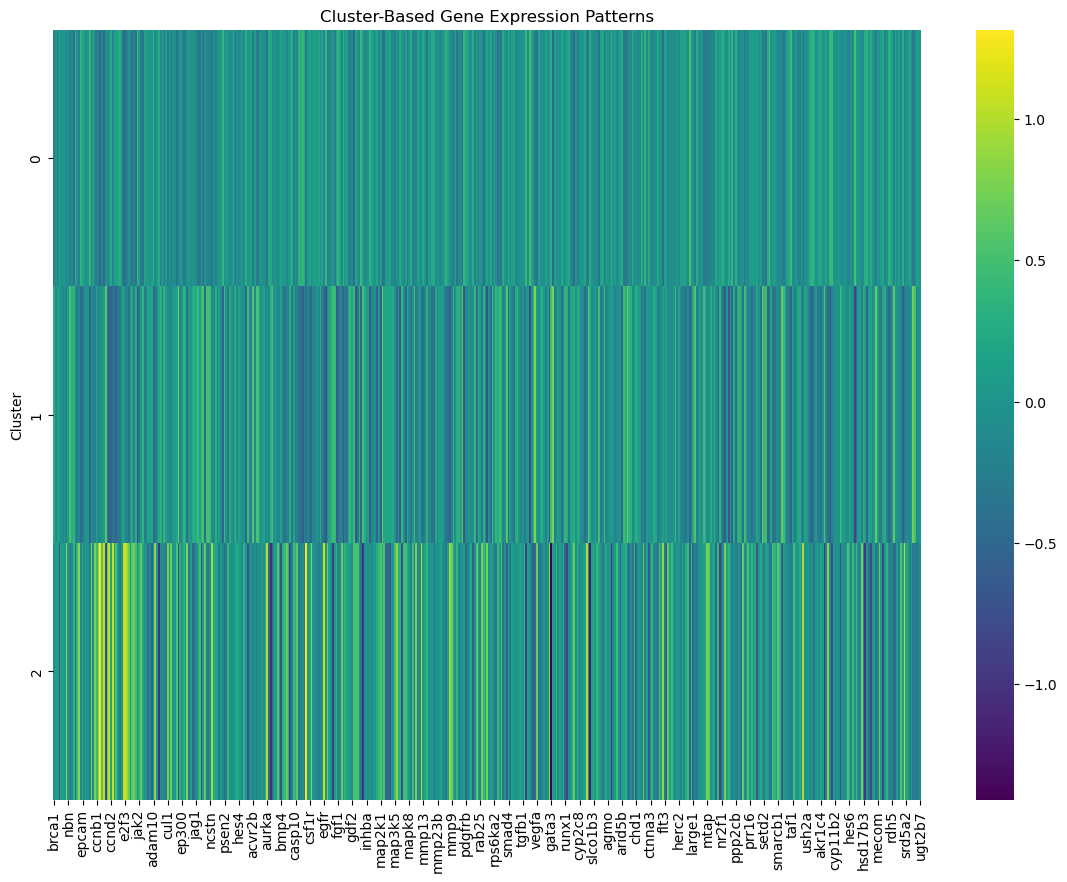

In [35]:
cluster_means = df.groupby("Cluster")[gene_cols].mean()

plt.figure(figsize=(14,10))
sns.heatmap(cluster_means, cmap='viridis')
plt.title("Cluster-Based Gene Expression Patterns")
plt.show()

### *“Cluster-Based Gene Expression Patterns”*

The heatmap shows the **average expression level of each gene** inside each cluster.

**In simple terms:**

- Each row is a **cluster** of patients.

- Each column is a **gene.**

- Colors show how active (or inactive) each gene is in that cluster.

**What it reveals:**

- Cluster 2 shows several genes with **much higher expression** (yellow spikes).
This means this group might have a more aggressive or distinct biological subtype.

- Clusters 0 and 1 look more similar but still have subtle differences.

This heatmap visually confirms that the clusters are **biologically meaningful**, not random.